<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Time_Series/%EA%B8%88%EC%9C%B5%20%ED%8C%8C%EC%9D%B4%EC%8D%AC%20%EC%BF%A1%EB%B6%81/9%EC%9E%A5_%EA%B8%88%EC%9C%B5%EC%97%90%EC%84%9C%EC%9D%98_%EA%B3%A0%EA%B8%89_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [29]:
!pip install jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer

In [19]:
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (GridSearchCV, cross_val_score, 
                                     RandomizedSearchCV, cross_validate, 
                                     StratifiedKFold)

In [6]:
from sklearn import metrics

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
from sklearn.base import clone 
from eli5.sklearn import PermutationImportance

In [161]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [170]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [175]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# Data

In [8]:
df = pd.read_csv('credit_card_default.csv', index_col=0, na_values='')

X = df.copy()
y = X.pop('default_payment_next_month')

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

num_features = X_train.select_dtypes(include='number').columns.to_list()
cat_features = X_train.select_dtypes(include='object').columns.to_list()

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

cat_list = [list(X_train[column].dropna().unique()) for column in cat_features]

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(categories=cat_list, sparse=False, 
                             handle_unknown='error', drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, num_features),
    ('categorical', cat_pipeline, cat_features)],
    remainder='drop')

# 고급 분류기 조사

In [9]:
def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:

        if labels is None:
            labels = ['Negative', 'Positive']

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle('Performance Evaluation', fontsize=16)

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": 'center', "va": 'center'})
        ax[0].set(xlabel='Predicted label',
                  ylabel='Actual label', title='Confusion Matrix')
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f}')
        ax[1].set(xlabel='False Positive Rate',
                  ylabel='True Positive Rate', title='ROC Curve')
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), 'ro',
                   markersize=8, label='Decision Point')
        ax[1].plot([0, 1], [0, 1], 'r--')
        ax[1].legend(loc='lower right')

        if show_pr_curve:

            ax[2].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
            ax[2].set(xlabel='Recall', ylabel='Precision',
                      title='Precision-Recall Curve')
            ax[2].legend()

    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'cohens_kappa': metrics.cohen_kappa_score(y_test, y_pred),
             'roc_auc': roc_auc,
             'pr_auc': pr_auc}

    return stats

In [10]:
LABELS = ['No Default', 'Default']

## 랜덤 포레스트

* 일련의 더 작은 모델을 학습하고 이르 사용해 예측

배깅

* 각 트리는 사용 가능한 모든 관측값의 하위 집합으로 훈련
* 각 트리에 사용된 총 관측값 수는 훈련 집합의 총계와 동일
* 단일 트리가 특정 데이터셋과 관련해 높은 분산을 가질 수 있지만,
* 포레스트는 편향을 증가시키지 않으면서 전체적으로 분산을 더 낮춘다
* 이상치가 있더라도 모든 트리에서 사용되지는 않을 것이므로 특이값의 영향을 줄일 수 도 있다
* 각 트리는 분할을 만들고자 모든 특징의 부분 집합만 고려


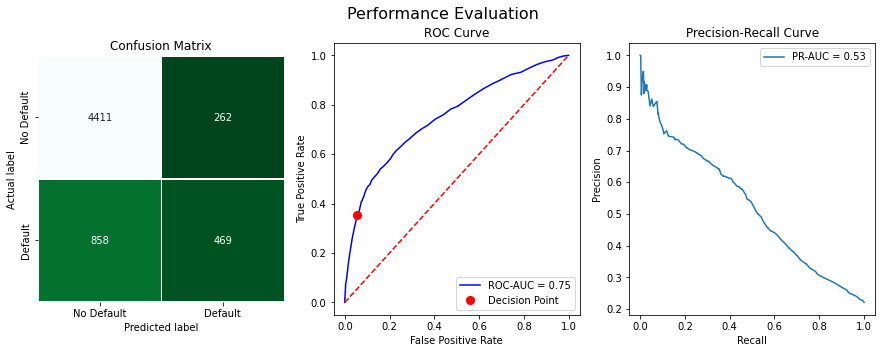

In [11]:
rf = RandomForestClassifier(random_state = 2022)

rf_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                ('classifier', rf)])

rf_pipeline.fit(X_train, y_train)

rf_pref = performance_evaluation_report(rf_pipeline,
                                        X_test, y_test,
                                        labels=LABELS,
                                        show_plot=True,
                                        show_pr_curve=True)

In [12]:
rf_pref

{'accuracy': 0.8133333333333334,
 'precision': 0.6415868673050615,
 'recall': 0.35342878673700073,
 'specificity': 0.9439332334688637,
 'f1_score': 0.4557823129251701,
 'cohens_kappa': 0.3543382226199533,
 'roc_auc': 0.7501155848723553,
 'pr_auc': 0.5260952830920238}

## 그래디언트 부스트 트리

* 여러 약한 학습자를 훈련시키고 결합해 강력한 학습자를 얻는 것이다
* 순차적/반복 알고리즘
* 첫 번째 약한 학습자부터 시작해 이후의 각 학습자에 대해 이전 학습자의 실수로부터 학습하도록 한다
* 그래디언트 하강은 손실 함수의 그래디언트를 사용해 전체 손실을 최소화하고 최상의 성능을 얻는다
* 그래디언트 하강 절차를 수행하고자 손실 함수의 값을 줄이는 트리를 모델에 추가한다

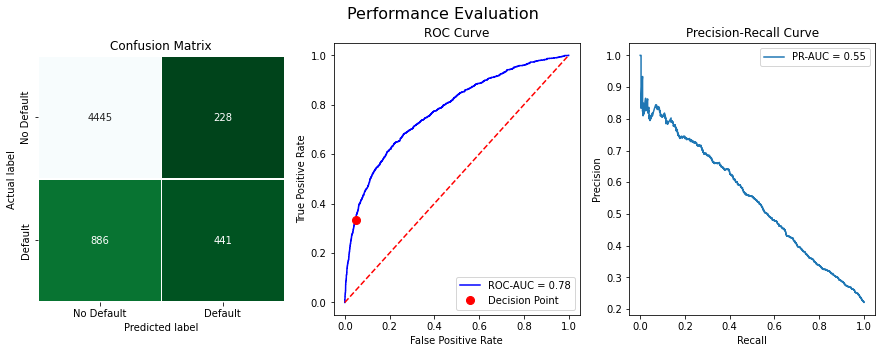

In [13]:
gbt = GradientBoostingClassifier(random_state = 2022)

gbt_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                 ('classifier', gbt)])

gbt_pipeline.fit(X_train, y_train)

gbt_perf = performance_evaluation_report(gbt_pipeline,
                                        X_test, y_test,
                                        labels=LABELS,
                                        show_plot=True,
                                        show_pr_curve=True)

In [14]:
gbt_perf

{'accuracy': 0.8143333333333334,
 'precision': 0.6591928251121076,
 'recall': 0.33232856066315,
 'specificity': 0.9512090734003852,
 'f1_score': 0.44188376753507014,
 'cohens_kappa': 0.34473633284100336,
 'roc_auc': 0.775486121671563,
 'pr_auc': 0.5474742234717066}

## XG부스트

* 기 분류된 알고리즘과 히스토그램 기반 알고리즘을 결합해 최상의 분할을 계산
* 그래디언트 부스트 트리의 비효율적 문제, 즉 새로운 가지를 만들 때 가능한 모든 분할에 대한 잠재적 손실을 고려하는 문제를 해결
* 부스팅을 위해 뉴턴-랩슨 방법을 사용
* 

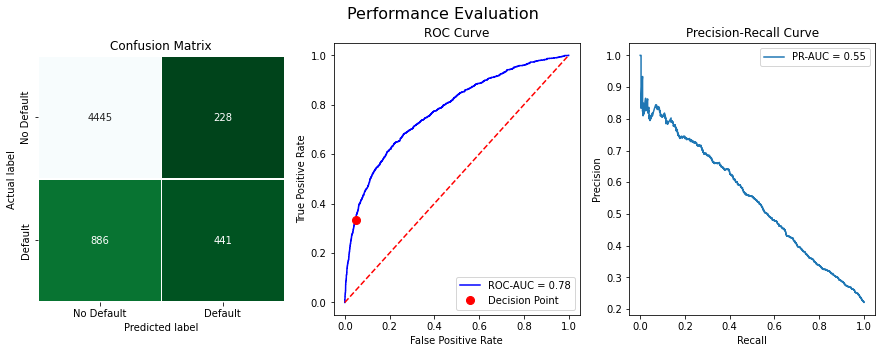

In [15]:
xgb = XGBClassifier(random_state = 2022)

xgb_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                 ('classifier', xgb)])

xgb_pipeline.fit(X_train, y_train)

xgb_perf = performance_evaluation_report(gbt_pipeline,
                                        X_test, y_test,
                                        labels=LABELS,
                                        show_plot=True,
                                        show_pr_curve=True)

In [16]:
xgb_perf

{'accuracy': 0.8143333333333334,
 'precision': 0.6591928251121076,
 'recall': 0.33232856066315,
 'specificity': 0.9512090734003852,
 'f1_score': 0.44188376753507014,
 'cohens_kappa': 0.34473633284100336,
 'roc_auc': 0.775486121671563,
 'pr_auc': 0.5474742234717066}

## Light GBM

* 트리가 잎 방향으로 자란다
* 잎 방향 알고리즘은 손실 함수가 최대로 감소된 잎을 선택
* 그래디언트 - 기반 원 - 사이드 샘플링이라는 기술을 사용해 최상의 분할값을 찾고자 데이터 인스턴스를 필터링한다
* Exclusive Feature Bundling (EFB)를 사용해 희소 데이터셋을 활용하고 상호 배타적인 특징을 함께 묶는다 -> 특징 공간의 복잡도를 감소시킴
* 소규모 데이터셋에는 쉽게 과적합할 수 있음 

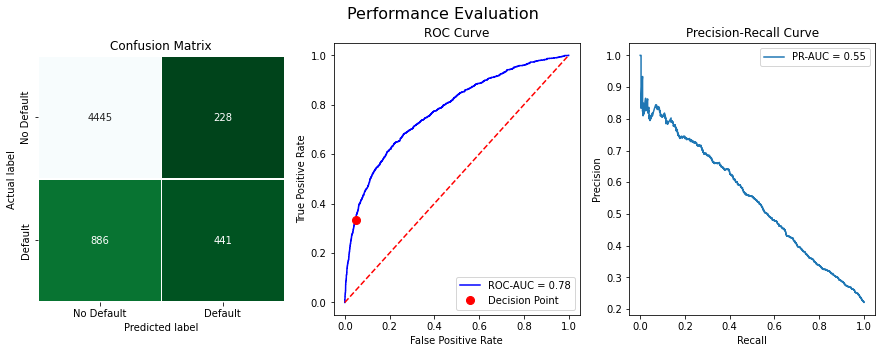

In [17]:
lgbm = LGBMClassifier(random_state = 2022)

lgbm_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                  ('classifier', lgbm)])

lgbm_pipeline.fit(X_train, y_train)
lgbm_perf = performance_evaluation_report(gbt_pipeline,
                                        X_test, y_test,
                                        labels=LABELS,
                                        show_plot=True,
                                        show_pr_curve=True)

In [18]:
lgbm_perf

{'accuracy': 0.8143333333333334,
 'precision': 0.6591928251121076,
 'recall': 0.33232856066315,
 'specificity': 0.9512090734003852,
 'f1_score': 0.44188376753507014,
 'cohens_kappa': 0.34473633284100336,
 'roc_auc': 0.775486121671563,
 'pr_auc': 0.5474742234717066}

# 성능 향상을 위해 스태킹 사용

In [113]:
RANDOM_STATE = 2022

k_fold = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)

df = pd.read_csv('/content/credit_card_fraud 2.csv')

X = df.copy()
y = X.pop('Class')

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=2022)

num_features = X_train.select_dtypes(include='number').columns.to_list()
cat_features = X_train.select_dtypes(include='object').columns.to_list()

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

cat_list = [list(X_train[column].dropna().unique()) for column in cat_features]

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(categories=cat_list, sparse=False, 
                             handle_unknown='error', drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, num_features),
    ('categorical', cat_pipeline, cat_features)],
    remainder='drop')

In [102]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [103]:
X.shape, y.shape

((284807, 30), (284807,))

In [104]:
X.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [105]:
clf_list = [('dec_tree', DecisionTreeClassifier(random_state=RANDOM_STATE)),
            ('log_reg', LogisticRegression()),
            ('knn', KNeighborsClassifier()),
            ('naive_bayes', GaussianNB())]

In [106]:
for model_tuple in clf_list:

    model = model_tuple[1]

    if 'random_state' in model.get_params().keys():

        model.set_params(random_state=RANDOM_STATE)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    recall = metrics.recall_score(y_pred, y_test)
    
    print(f"{model_tuple[0]}'s recall score: {recall:.4f}")

dec_tree's recall score: 0.7426
log_reg's recall score: 0.9333
knn's recall score: 0.9125
naive_bayes's recall score: 0.0600


In [107]:
lr = LogisticRegression()

stack_clf = StackingClassifier(clf_list, 
                               final_estimator=lr,
                               cv=k_fold,
                               n_jobs=-1)

stack_clf.fit(X_train, y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=2022, shuffle=True),
                   estimators=[('dec_tree',
                                DecisionTreeClassifier(random_state=2022)),
                               ('log_reg',
                                LogisticRegression(random_state=2022)),
                               ('knn', KNeighborsClassifier()),
                               ('naive_bayes', GaussianNB())],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [108]:
y_pred = stack_clf.predict(X_test)
recall = metrics.recall_score(y_pred, y_test)

print(f"The stacked ensemble's recall score: {recall:.4f}")

The stacked ensemble's recall score: 0.9178


# 특징 중요도 조사

* 모델의 논리를 이해함으로써 이론적으로 정확성을 확인하는 것은 물론 중요한 변수에만 초점을 맞춰 모델을 개선해 볼 수 있다

* 특징 중요도를 사용하면 x개의 중요 특징을 유지함으로써 성능을 향상시킬 뿐만 아니라 훈련 시간을 단축할 수 있다

* 특정 실사례에서 해석을 위해 정확도를 희생하는 것이 합리적일 경우가 있다

**Scikit - Learn의 특징 중요도**

* 의사결정 트리를 훈련시킬 때 각 특징이 가중 불순도 감소에 얼머나 기여헀는지 계산할 수 있다

* 전체 트리의 중요도를 계산하고자 알고리즘은 전체 트리에 대해 불순도 감소를 평균화한다

장점

* 빠른 계산
* 쉬운 추출

단점

* 편향 - 연속 특징이나 높은 카디널리티 범주형 변수의 중요도를 부풀리는 경향이 있다

* 불순도 기반 중요도는 훈련 집합을 기반으로 계산되며, 낯선 데이터로의 일반화할 수 있는 모델의 능력을 반영하지 않는다

**순열 특징 중요도**

* 특징 중요도를 직접 측정
* 각 예측 변수를 랜덤하게 섞으면서 모델의 성능에 어떤 영향을 미치는지 관찰한다
* 섞을 때는 변수의 분포를 유지한다

알고리즘 단계

* 기준 모델을 학습하고 관심 점수를 기록한다
* 특징 중 하나의 값을 임의로 순열하고, 전체 데이터셋을 사용해 예측을 구하고 점수를 기록한다
* 특징 중요도는 기준 점수와 순열된 데이터셋의 점수 간의 차이이다
* 모든 특징에 대해 2단계를 반복한다

장점

* 모델에 구애받지 않는다
* 상히 효과적이다

단점

* 기본 특징 중요도에 비해 계산량이 더 많다
* 상관된 예측 변수의 중요도를 과평가한다

**특징 중요도 열 제거**

* 모든 특징이 포함된 모델을, 특징 중 하나를 제거한 것으로 훈련과 추론한 모델과 비교한다

장점

* 가장 정확/신뢰할 수 있는 특징 중요도

단점

* 데이터셋의 각 변형 모델을 유지하고자 잠재적으로 계산 비용이 높아진다

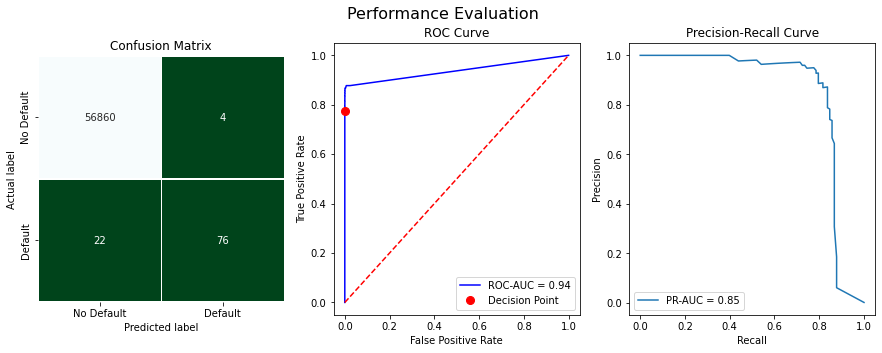

In [118]:
rf = RandomForestClassifier(random_state = 2022)

rf_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                ('classifier', rf)])

rf_pipeline.fit(X_train, y_train)

rf_pref = performance_evaluation_report(rf_pipeline,
                                        X_test, y_test,
                                        labels=LABELS,
                                        show_plot=True,
                                        show_pr_curve=True)

In [119]:
rf_classifier = rf_pipeline.named_steps['classifier']
preprocessor = rf_pipeline.named_steps['preprocessor']

In [127]:
feat_names = preprocessor.named_transformers_['categorical']

feat_names = np.r_[num_features, feat_names]

X_train_preprocessed = pd.DataFrame(preprocessor.transform(X_train))

In [129]:
rf_feat_imp = pd.DataFrame(rf_classifier.feature_importances_,
                           #index = feat_names,
                           columns = ['mdi'])

rf_feat_imp['cumul_importance_mdi'] = np.cumsum(rf_feat_imp.mdi)

In [130]:
def plot_most_important_features(feat_imp, method='MDI', n_features=10, bottom=False):
    
    if bottom:
        indicator = 'Bottom'
        feat_imp = feat_imp.sort_values(ascending=True)
        
    else:
        indicator = 'Top'
        feat_imp = feat_imp.sort_values(ascending=False)
        
    ax = feat_imp.head(n_features).plot.barh()
    ax.invert_yaxis()
    ax.set(title=('Feature importance - '
                  f'{method} ({indicator} {n_features})'), 
           xlabel='Importance', 
           ylabel='Feature')
    
    return ax

누적 중요도

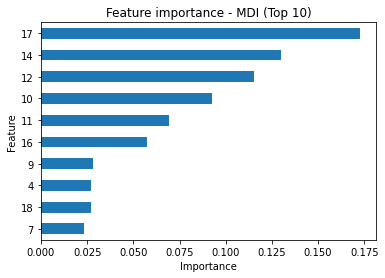

In [131]:
plot_most_important_features(rf_feat_imp.mdi, method='MDI')

In [133]:
print(f'Top 10 features account for {100 * rf_feat_imp.head(10).mdi.sum():.2f}% of the total importance.')
print(f'Top {rf_feat_imp[rf_feat_imp.cumul_importance_mdi <= 0.95].shape[0]} features account for 95% of importance.')

Top 10 features account for 18.23% of the total importance.
Top 26 features account for 95% of importance.


순열 중요도

In [162]:
perm = PermutationImportance(rf_classifier, n_iter = 25, random_state=RANDOM_STATE)

perm.fit(X_train_preprocessed, y_train)
rf_feat_imp['permutation'] = perm.feature_importances_

ValueError: ignored

In [ ]:
plot_most_important_features(rf_feat_imp.permutation, method='Permutation')

열 특징 중요도 삭제

In [ ]:
def drop_col_feat_imp(model, X, y, random_state = RANDOM_STATE):
    
    model_clone = clone(model)
    model_clone.random_state = random_state
    model_clone.fit(X, y)
    benchmark_score = model_clone.score(X, y)
    
    importances = []
    
    for col in X.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X.drop(col, axis = 1), y)
        drop_col_score = model_clone.score(X.drop(col, axis = 1), 
                                           y)
        importances.append(benchmark_score - drop_col_score)
    
    return importances


In [ ]:
rf_feat_imp['drop_column'] = drop_col_feat_imp(rf_classifier,
                                               X_train_preprocessed,
                                               y_train,
                                               random_state = RANDOM_STATE)

In [ ]:
plot_most_important_features(rf_feat_imp.drop_column, method='Drop column')

In [ ]:
plot_most_important_features(rf_feat_imp.drop_column, 
                             method='Drop column', 
                             bottom=True)

# 불균형 데이터 처리에 대한 다양한 접근 방식

In [145]:
df = pd.read_csv('credit_card_default.csv', index_col=0, na_values='')

X = df.copy()
y = X.pop('default_payment_next_month')

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

In [146]:
y.value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default_payment_next_month, dtype: float64

In [151]:
NUM_FEATURES = ['age']
CAT_FEATURES = ['education', 'marriage']

In [149]:
for col in NUM_FEATURES:

    num_imputer = KNNImputer()
    num_imputer.fit(X_train[[col]])
    
    X_train.loc[:, col] = num_imputer.transform(X_train[[col]])
    X_test.loc[:, col] = num_imputer.transform(X_test[[col]])

In [153]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=2022)

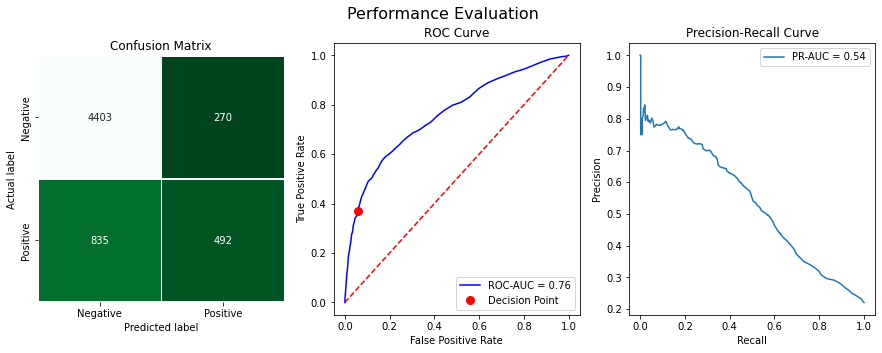

In [154]:
rf_perf = performance_evaluation_report(rf, X_test, y_test, 
                                        show_plot=True, 
                                        show_pr_curve=True)

In [155]:
rf_perf

{'accuracy': 0.8158333333333333,
 'precision': 0.6456692913385826,
 'recall': 0.3707611152976639,
 'specificity': 0.9422212711320351,
 'f1_score': 0.4710387745332695,
 'cohens_kappa': 0.3692713571568008,
 'roc_auc': 0.7602797968286445,
 'pr_auc': 0.536935775326712}

**과소 표본 추출**

* 다수 부류를 과소 표본 추출하는 것
* 다수 부류에서 랜덤 샘플을 추출해 1:1 또는 타깃 부류 사이의 다른 원하는 비율을 얻는다
* 훈련된 모델의 정확도가 떨어질 수 있다
* 훈련과 테스트 집합의 분포가 리샘플링 후 동일하지 않기 때문에 가능한 다른 거짓 긍정의 수가 증가한다. 이로 인해 편향된 분류기가 생성된다

The new class proportions are: {0: 5309, 1: 5309}


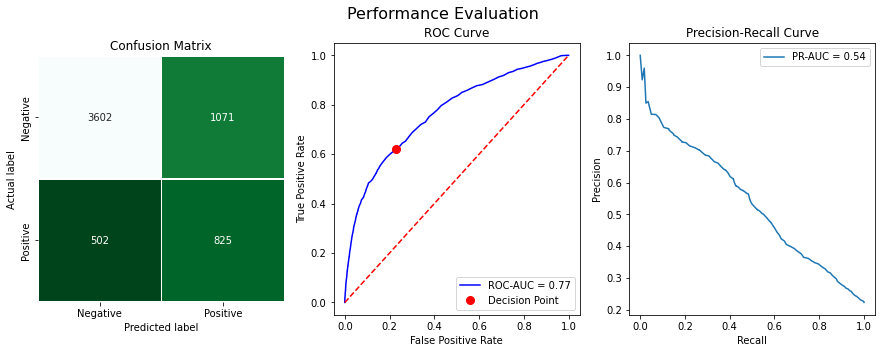

In [163]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print(f'The new class proportions are: {dict(Counter(y_rus))}')

rf.fit(X_rus, y_rus)
rf_rus_perf = performance_evaluation_report(rf, X_test, y_test, 
                                            show_plot=True, 
                                            show_pr_curve=True)

In [164]:
rf_rus_perf

{'accuracy': 0.7378333333333333,
 'precision': 0.435126582278481,
 'recall': 0.6217030896759608,
 'specificity': 0.7708110421570725,
 'f1_score': 0.5119453924914675,
 'cohens_kappa': 0.3402775447755685,
 'roc_auc': 0.7667032033659992,
 'pr_auc': 0.5382845005056435}

**과표본 추출**

* 원하는 비율에 도달할 때까지 소수 부류를 대체해 여러 번 샘플링 한다
* 데이터 삭제로 인한 정보 손실이 없으므로 종종 과소 표본 추출보다 서능이 뛰어나다
* 소수 부류의 관측값 복제로 인해 과적합의 위험이 있다

The new class proportions are: {0: 18691, 1: 18691}


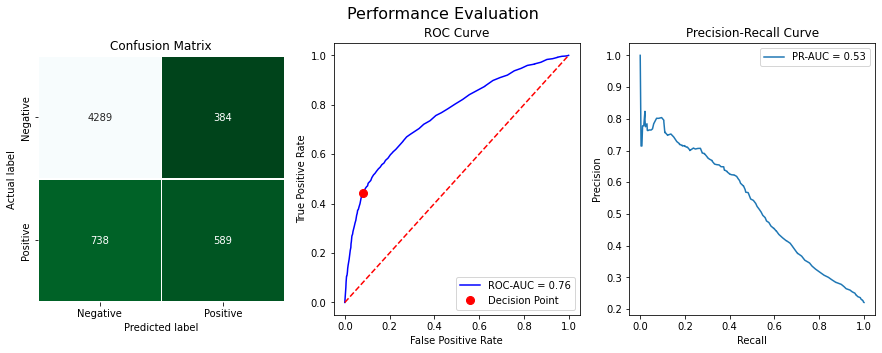

In [165]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print(f'The new class proportions are: {dict(Counter(y_ros))}')

rf.fit(X_ros, y_ros)
rf_ros_perf = performance_evaluation_report(rf, X_test, y_test, 
                                            show_plot=True, 
                                            show_pr_curve=True)

In [166]:
rf_ros_perf

{'accuracy': 0.813,
 'precision': 0.605344295991778,
 'recall': 0.44385832705350414,
 'specificity': 0.9178258078322277,
 'f1_score': 0.5121739130434783,
 'cohens_kappa': 0.39987473321080036,
 'roc_auc': 0.7601023274850424,
 'pr_auc': 0.5282344547662412}

**SMOTE**

* 소수 부류에서 새로운 합성 관측값을 생성하는 고급 과표본 추출 알고리즘
* 과적합 문제 해결
* k-NN 알고리즘을 사용해 k-최근접 이웃을 식별하고 그 연결선에 보간되는 새로운 합성 관측값을 만든다

The new class proportions are: {0: 18691, 1: 18691}


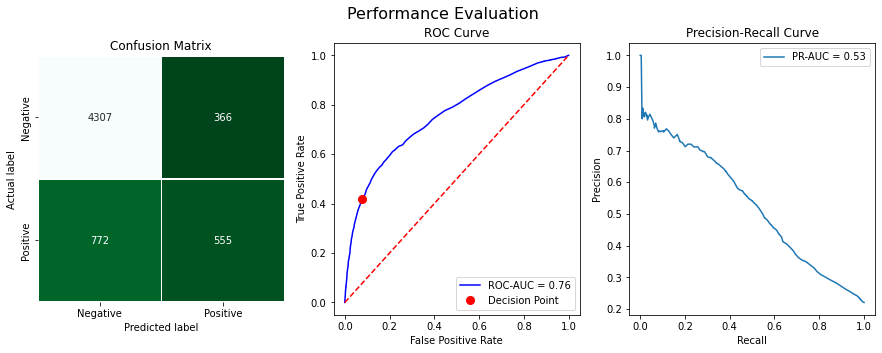

In [167]:
X_smote, y_smote = SMOTE(random_state=RANDOM_STATE).fit_resample(X_train, y_train)
print(f'The new class proportions are: {dict(Counter(y_smote))}')
rf.fit(X_smote, y_smote)
rf_smote_perf = performance_evaluation_report(rf, X_test, y_test, 
                                              show_plot=True, 
                                              show_pr_curve=True)

In [168]:
rf_smote_perf

{'accuracy': 0.8103333333333333,
 'precision': 0.6026058631921825,
 'recall': 0.41823662396382816,
 'specificity': 0.921677723090092,
 'f1_score': 0.4937722419928825,
 'cohens_kappa': 0.38172704607328756,
 'roc_auc': 0.7555381965470158,
 'pr_auc': 0.5279355743355716}

**ADASYN**

* 특정점에 대해 생성되는 관측값 수가 SMOTE와 같이 모든 점에 대해 균일한 가중치가 아니라 밀도 분포에 의해 결정된다

단점

* 소수 관측값이 희소하게 분포된 경우에 따른 적응성 및 어려움으로 알고리즘의 정밀도가 저하될 수 있다

The new class proportions are: {0: 18691, 1: 19142}


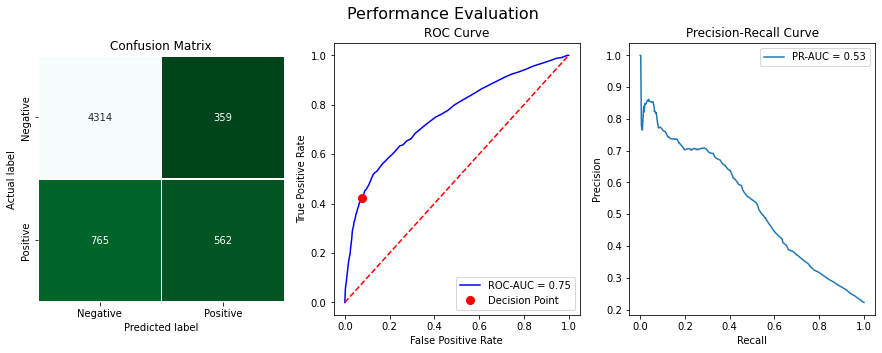

In [169]:
X_adasyn, y_adasyn = ADASYN(random_state=RANDOM_STATE).fit_resample(X_train, y_train)
print(f'The new class proportions are: {dict(Counter(y_adasyn))}')
rf.fit(X_adasyn, y_adasyn)
rf_adasyn_perf = performance_evaluation_report(rf, X_test, y_test, 
                                               show_plot=True, 
                                               show_pr_curve=True)

BalancedRandomForestClassifier

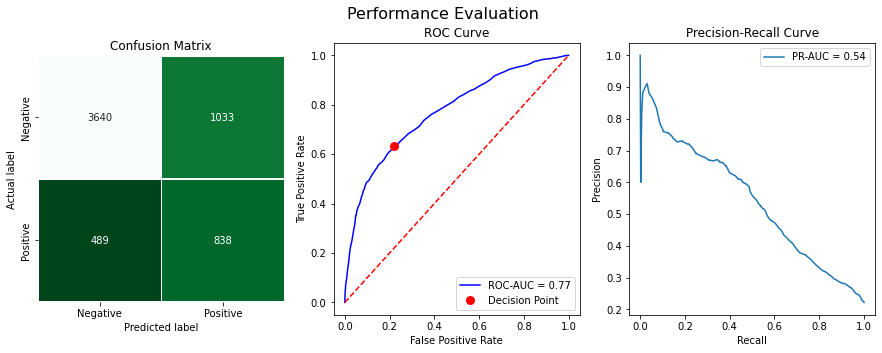

In [171]:
balanced_rf = BalancedRandomForestClassifier(random_state=RANDOM_STATE)

balanced_rf.fit(X_train, y_train)
balanced_rf_perf = performance_evaluation_report(balanced_rf, 
                                                 X_test, y_test, 
                                                 show_plot=True, 
                                                 show_pr_curve=True)

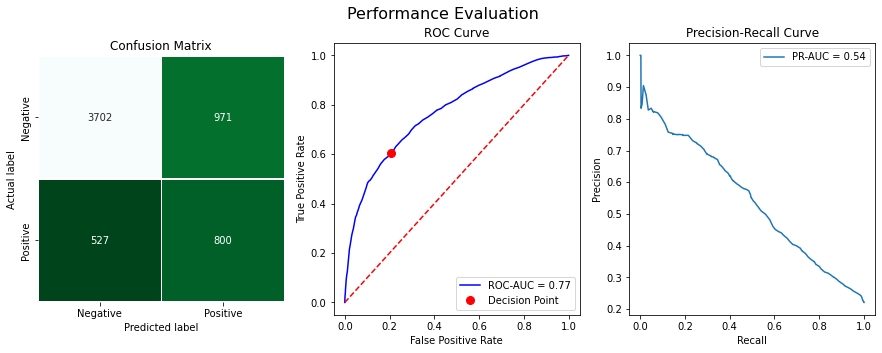

In [172]:
balanced_rf_cw = BalancedRandomForestClassifier(
    random_state=RANDOM_STATE, 
    class_weight='balanced',
    n_jobs=-1)

balanced_rf_cw.fit(X_train, y_train)
balanced_rf_cw_perf = performance_evaluation_report(balanced_rf_cw, 
                                                    X_test, y_test, 
                                                    show_plot=True, 
                                                    show_pr_curve=True)

In [174]:
performance_results = {'random_forest': rf_perf,
                       'undersampled rf': rf_rus_perf,
                       'oversampled_rf': rf_ros_perf,
                       'smote': rf_smote_perf,
                       'adasyn': rf_adasyn_perf,
                       'balanced_random_forest': balanced_rf_perf,
                       'balanced_random_forest_cw': balanced_rf_cw_perf}
pd.DataFrame(performance_results).T

,accuracy,precision,recall,specificity,f1_score,cohens_kappa,roc_auc,pr_auc
random_forest,0.815833,0.645669,0.370761,0.942221,0.471039,0.369271,0.760280,0.536936
undersampled rf,0.737833,0.435127,0.621703,0.770811,0.511945,0.340278,0.766703,0.538285
oversampled_rf,0.813000,0.605344,0.443858,0.917826,0.512174,0.399875,0.760102,0.528234
smote,0.810333,0.602606,0.418237,0.921678,0.493772,0.381727,0.755538,0.527936
adasyn,0.812667,0.610206,0.423512,0.923176,0.500000,0.389333,0.754946,0.530843
balanced_random_forest,0.746333,0.447889,0.631500,0.778943,0.524078,0.357913,0.771054,0.541972
balanced_random_forest_cw,0.750333,0.451722,0.602864,0.792211,0.516462,0.352812,0.770812,0.543260


# 베이즈 초매개 변수 최적화

In [176]:
N_FOLDS = 5
MAX_EVALS = 200

In [177]:
df = pd.read_csv('/content/credit_card_fraud 2.csv')

X = df.copy()
y = X.pop('Class')

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

In [178]:
def objective(params, n_folds = N_FOLDS, random_state=42):
    
    model = LGBMClassifier(**params)
    model.set_params(random_state=random_state)
    
    k_fold = StratifiedKFold(n_folds, shuffle=True, 
                             random_state=random_state)
    
    metrics = cross_val_score(model, X_train, y_train, 
                              cv=k_fold, scoring='recall')
    loss = -1 * metrics.mean()
    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [179]:
lgbm_param_grid = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss']),
    'max_depth': hp.choice('max_depth', [-1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
    'n_estimators': hp.choice('n_estimators', [10, 50, 100, 
                                               300, 750, 1000]),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    'learning_rate': hp.uniform ('learning_rate', 0.05, 0.3),
}

In [ ]:
trials = Trials()
best_set = fmin(fn= objective,
                space= lgbm_param_grid,
                algo= tpe.suggest,
                max_evals = MAX_EVALS,
                trials= trials)

 15%|█▌        | 30/200 [39:41<2:34:10, 54.41s/it, best loss: -0.9213891593638429]

In [ ]:
best_set